<h1><span style="color:#b75591">
HANDWRITTEN LETTERS RECOGNIZER <span style="color:#b73591"></h1>

<h3>Project Description
</h3>
<p>
The project aims to accurately identify each letter in a handwriting dataset of a popular language alphabet. The dataset consists of various handwriting samples for each individual character, collected from different individuals in real time. The CNN model that I have prepared achieves high accuracy and low loss values in identifying the alphabets.

<h3>Creating DataFrame
</h3>
<p>
The dataset in CSV format is first converted to a Spark DataFrame and then converted into a Pandas DataFrame. This process is necessary because Pandas can only read files in the local environment, whereas in Databricks, the tables are stored in a different location. On the other hand, Spark can read files from various locations, including the files stored in Databricks.

In [0]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from random import randint, choice
from pyspark.sql import SparkSession
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

df = SparkSession.builder.getOrCreate().read.format('csv').load("dbfs:/FileStore/tables/A_Z_Handwritten_Data.csv", header=True, inferSchema=True).toPandas()
df

,00,01,02,03,04,05,06,07,08,09,010,011,012,013,014,015,016,017,018,019,020,021,022,023,024,025,026,027,028,029,030,031,032,033,034,035,036,037,038,039,...,0745,0746,0747,0748,0749,0750,0751,0752,0753,0754,0755,0756,0757,0758,0759,0760,0761,0762,0763,0764,0765,0766,0767,0768,0769,0770,0771,0772,0773,0774,0775,0776,0777,0778,0779,0780,0781,0782,0783,0784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<p>
The dataset consists of 372450 rows and 785 columns. The first column represents the target value, while the remaining columns contain the pixel values of the images.

In [0]:
df.shape

(372450, 785)

<h3>
<p>Reshaping Data</h3>
<p>
The features of the dataset, which are the pixel values of each image, are reshaped into a matrix with the following dimensions.

In [0]:
images = df.iloc[:, 1:].values.reshape(df.shape[0], 28, 28, 1)
images[0]

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

<h3>Target Value
</h3>
<p>
The First column of the Dataset represents the Target value, which is a range of numbers from 0 to 25. Each number corresponds to a letter in the alphabet.

In [0]:
 df.iloc[:,0].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

The target value is saved as an nd Array with the name **'label'**.

In [0]:
label = df.iloc[:,0].values
label[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

<h3>Letter Distribution in the Dataset</h3>
<p>
The occurrences of each letter in the dataset are calculated and the results are as follows:

In [0]:
string.ascii_letters[26:]

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [0]:
letters = list(string.ascii_letters[26:])
LetterCounts = dict(zip(letters, [0]*26))
for l in label:
    LetterCounts[letters[l]] += 1

print(LetterCounts)

{'A': 13869, 'B': 8668, 'C': 23409, 'D': 10134, 'E': 11440, 'F': 1163, 'G': 5762, 'H': 7218, 'I': 1120, 'J': 8493, 'K': 5603, 'L': 11586, 'M': 12336, 'N': 19010, 'O': 57825, 'P': 19341, 'Q': 5812, 'R': 11566, 'S': 48419, 'T': 22495, 'U': 29008, 'V': 4182, 'W': 10784, 'X': 6272, 'Y': 10859, 'Z': 6076}


<p>
It can be easily observed from the bar chart below that the number of letters in the dataset varies significantly.

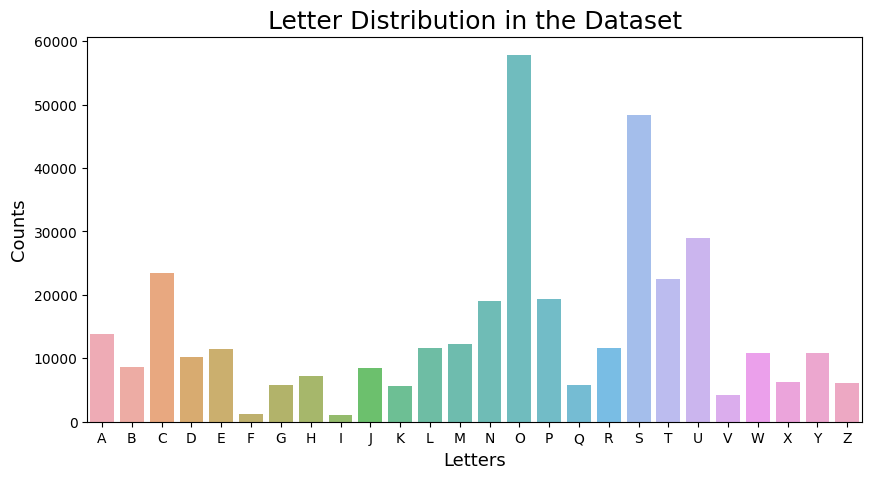

In [0]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x=list(LetterCounts), y=list(LetterCounts.values()), alpha=.8)
plt.title('Letter Distribution in the Dataset', fontsize=18)
plt.xlabel("Letters", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.show()

<h3>Splitting Dataset into Train and Test Sets
</h3>
<p>
The image pixels and labels are split into their corresponding Train and Test sets, with 80% of the data allocated to the Train set and 20% to the Test set. The split is performed in a stratified manner according to the labels, ensuring that the distribution of labels is preserved in both the Train and Test sets.

In [0]:
from sklearn.model_selection import train_test_split

X_Train, X_Test, y_Train, y_Test = train_test_split(images, label, stratify=label, test_size=0.20, random_state=0)

<p>
Lists containing the corresponding characters for the numeric label values in the Train and Test labels are created.

In [0]:
y_Train_As_Str, y_Test_As_Str = [letters[i] for i in y_Train], [letters[i] for i in y_Test]
print(sorted(set(y_Train_As_Str), key=lambda x: ord(x)))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


<h3>
<p>Function For Plotting Letters</h3>
<p>
An image of each letter is plotted alongside the letter itself.

In [0]:
def plotALetter(X, y, index):
    plt.figure(figsize = (2.5, 2.5))
    plt.imshow(X[index])
    plt.xlabel(y[index], fontsize=16)

<h3>
<p>Letter Plot Examples</h3>
<p>
An image of a random letter is drawn.

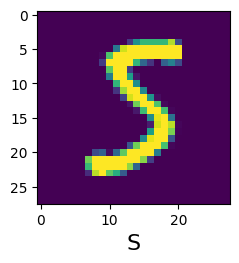

In [0]:
plotALetter(X_Train, y_Train_As_Str, randint(0, len(y_Train)))

<p>
Here is a figure illustrating 8 randomly selected letters.

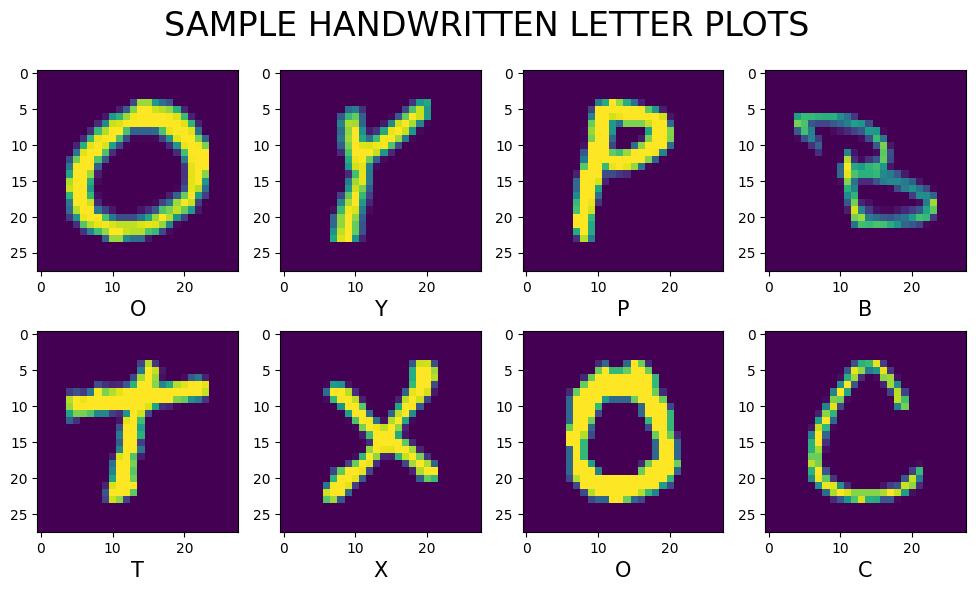

In [0]:
fig,axs=plt.subplots(2,4, figsize=(12, 6))
fig.suptitle("SAMPLE HANDWRITTEN LETTER PLOTS", fontsize=24)
plt.subplots_adjust(hspace=0.3)
for (i, rand_index) in [(i, randint(0, len(y_Train))) for i in range(8)]:
    axs[i // 4, i % 4].imshow(X_Train[rand_index])
    axs[i // 4, i % 4].set_xlabel(y_Train_As_Str[rand_index], fontsize=15)

plt.show()



<p>
Below are some plot examples for the letter <b>'C'</b>. Not all handwritten <b>'C'</b> characters are clear in the first image. For example, in the fifth image, it appears that the character can be interpreted as <b>'O'</b> instead of <b>'C'</b>.

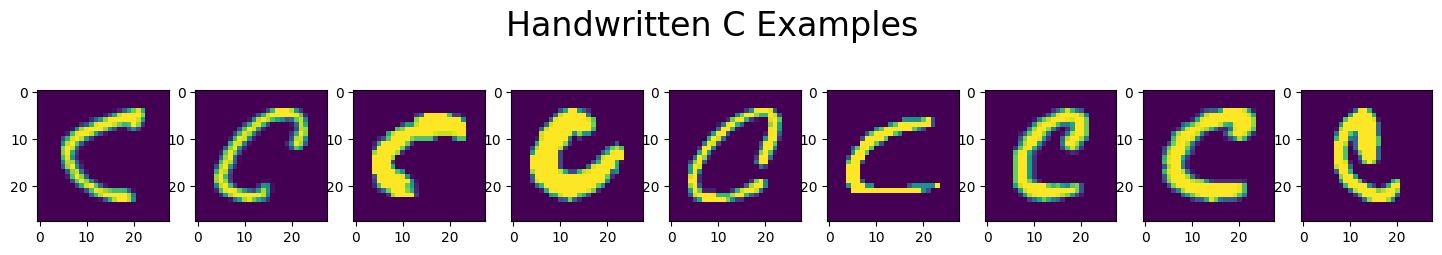

In [0]:
fig,axs=plt.subplots(1,9, figsize=(18, 3))
fig.suptitle("Handwritten C Examples", fontsize=24)
for (i, rand_index) in [(i, choice(np.where(y_Train == 2)[0].tolist())) for i in range(9)]:
    axs[i].imshow(X_Train[rand_index])
plt.show()

<p>
Sometimes the character may not resemble any specific letter, as can be observed in the penultimate image depicting the letter <b>'R'</b>.

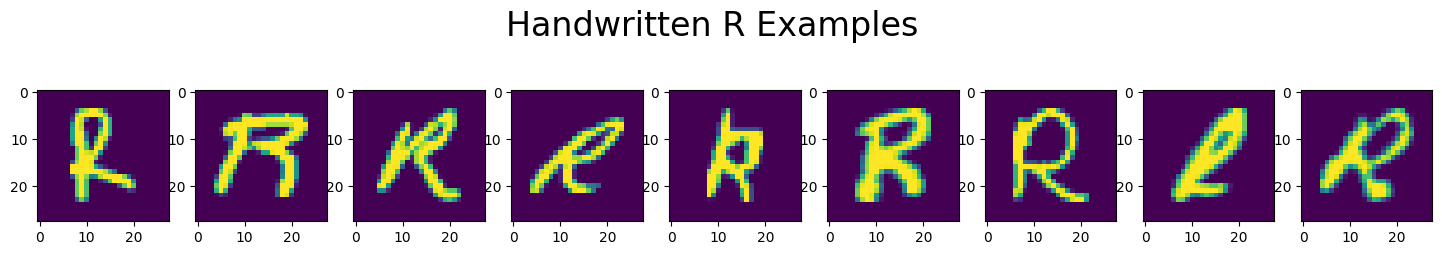

In [0]:
fig,axs=plt.subplots(1,9, figsize=(18, 3))
fig.suptitle("Handwritten R Examples", fontsize=24)
for (i, rand_index) in [(i, choice(np.where(y_Train == 17)[0].tolist())) for i in range(9)]:
    axs[i].imshow(X_Train[rand_index])
plt.show()

<h3>
<p>Normalization</h3>
<p>
Normalization is performed by dividing the Train and Test features (image pixels) by 255.

In [0]:
X_TrainN = X_Train/255.0
X_TestN = X_Test/255.0

<h2>
<p>Convolutional Neural Network </h2>
<p>
The CNN model consists of 2 convolutional layers, 2 max pooling layers, 2 dense layers and a flatten layer. In the First Convolutional Layer, the Training set is passed through 26 filters with a kernel size of 3x3, and the ReLU activation function is applied. Then, in the next layer, the size of the data is reduced using max pooling. These two steps are repeated, but in the Second Convolutional Layer, the number of filters is increased by 2. After the data is further reduced in the Second Max Pooling Layer, it is flattened to be passed to a dense layer for fully connected processing. In the First Dense Layer, there are 52 neurons and the activation function used is ReLU. In the Final Dense Layer, there are 26 neurons, which corresponds to the number of letters in the alphabet. In this layer, probabilities are calculated for each image, representing the likelihood of each possible letter.

In [0]:
cnn = models.Sequential([
    layers.Conv2D(filters=26, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=52, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(52, activation='relu'),
    layers.Dense(26, activation='softmax')
])

<h3>
<p>Optimizing CNN with Adam</h3>
<p>
The CNN model is compiled with the Adam optimizer, Sparse Categorical Cross Entropy as the loss function, and Accuracy as the evaluation metric.

In [0]:
cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

<h3>
<p>Fitting CNN To Train Data</h3>
<p>
The normalized values of the image pixels from the Train set and the corresponding Train Labels are fitted to the CNN model and the Training Process is initiated. This process is repeated 10 times. Throughout the CNN Training Process, the Accuracy gradually increases, while the Loss value steadily decreases. This indicates the model's improvement during the Learning Phase.

In [0]:
TrainingProcess = cnn.fit(X_TrainN, y_Train, epochs=10)

Epoch 1/10
 299/9312 [...........

*** WARNING: max output size exceeded, skipping output. ***

1/1 [==============================] - 0s 412ms/step


INFO:tensorflow:Assets written to: /tmp/tmpmkqvrokb/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpmkqvrokb/model/data/model/assets


<h3>
<p>CNN Summary Report</h3>

In [0]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 26)        260       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 26)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 52)        12220     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 52)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1300)              0         
                                                                 
 dense (Dense)               (None, 52)                6

<h2>
<p>Visualization of CNN Training Results</h2>
<p>
The Accuracy and Loss results for each epoch are plotted separately in Line Charts to allow for a detailed view of the results. Additionally, in another Line Chart, they are plotted together to facilitate easier comparison between accuracy and loss values.

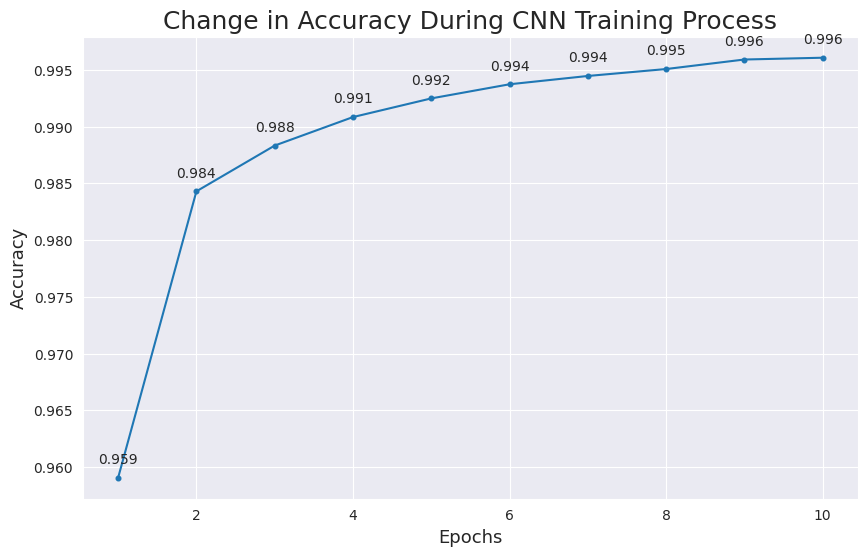

In [0]:
fig = plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.lineplot(x=range(1,11), y=TrainingProcess.history['accuracy'])

for epoch in range(10):
    accuracy = TrainingProcess.history['accuracy'][epoch]
    loss = TrainingProcess.history['loss'][epoch]
    plt.scatter(epoch+1, accuracy, color=sns.color_palette()[0], s=11)
    plt.text(epoch+1, accuracy + 0.001, f"{accuracy:.3f}", ha='center', va='bottom')

plt.title('Change in Accuracy During CNN Training Process', fontsize=18)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
fig.show()

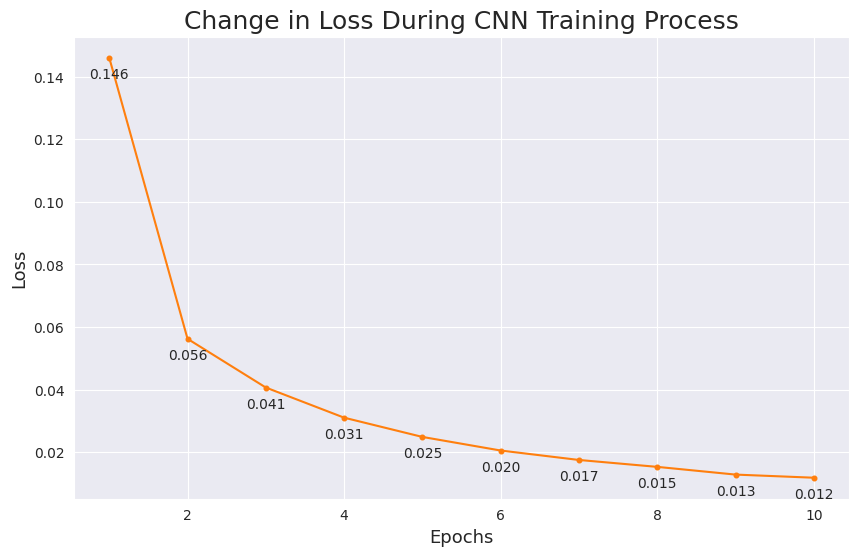

In [0]:
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1,11), y=TrainingProcess.history['loss'], color=sns.color_palette()[1])

for epoch in range(10):
    loss = TrainingProcess.history['loss'][epoch]
    plt.scatter(epoch+1, loss, color=sns.color_palette()[1], s=11)
    plt.text(epoch+1, loss - 0.003, f"{loss:.3f}", ha='center', va='top')

plt.title('Change in Loss During CNN Training Process', fontsize=18)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
fig.show()

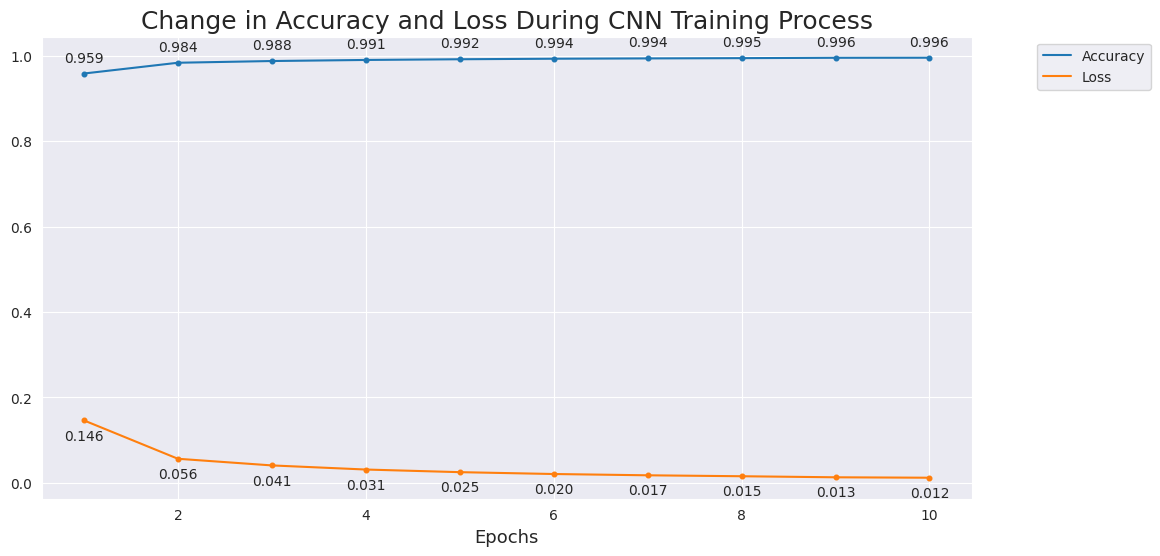

In [0]:
fig = plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1,11), y=TrainingProcess.history['accuracy'], label='Accuracy')
sns.lineplot(x=range(1,11), y=TrainingProcess.history['loss'], label='Loss')

for epoch in range(10):
    accuracy = TrainingProcess.history['accuracy'][epoch]
    loss = TrainingProcess.history['loss'][epoch]
    plt.scatter(epoch+1, accuracy, color=sns.color_palette()[0], s=11)
    plt.text(epoch+1, accuracy + 0.02, f"{accuracy:.3f}", ha='center', va='bottom')
    plt.scatter(epoch+1, loss, color=sns.color_palette()[1], s=11)
    plt.text(epoch+1, loss - 0.02, f"{loss:.3f}", ha='center', va='top')


plt.title('Change in Accuracy and Loss During CNN Training Process', fontsize=18)
plt.xlabel("Epochs", fontsize=13)
plt.legend(bbox_to_anchor=(1.2, 1))
fig.show()

<h3>
<p>Evaluation of CNN</h3>
<p>
The model is evaluated using the image pixel values from the Test Set and their corresponding Label values.

In [0]:
Evaluation = cnn.evaluate(X_TestN, y_Test)

 934/2328 [===========>..................] - ETA: 11s - loss: 0.0332 - accuracy: 0.9915

*** WARNING: max output size exceeded, skipping output. ***

2328/2328 [==============================] - 20s 8ms/step - loss: 0.0342 - accuracy: 0.9919


<p>
The left side represents the Loss value, while the right side represents the Accuracy score.

In [0]:
print(Evaluation)

[0.03423003479838371, 0.991945207118988]


<h3>
<p>Train and Test Results Comparison</h3>
<p>
It is observed that the Test Accuracy is slightly lower than the Accuracy achieved in the final epoch. Additionally, the Loss value is slightly higher than the Loss value in the final epoch.

In [0]:
fig = px.bar(x=["Accuracy", "Accuracy", "Loss", "Loss"], y=[TrainingProcess.history['accuracy'][-1], Evaluation[1], TrainingProcess.history['loss'][-1], Evaluation[0]], 
             color=["Train", "Test", "Train", "Test"], barmode="group", width=800, height=500, color_discrete_sequence=px.colors.sequential.Agsunset[0::6])

fig.update_layout(title="Train and Test Results Comparison", title_font=dict(size=24), xaxis_title="Metrics", yaxis_title="", legend_title="")
fig.show()

<h3>Predictions for Test Set </h3>
<p>
The model predicted the label values for Test Set, and the results are obtained as probabilities for each image and each label.

In [0]:
Preds = cnn.predict(X_TestN)
Preds[0]

2328/2328 [==============================] - 19s 8ms/step


array([9.5032792e-29, 1.3109378e-18, 1.7847802e-09, 2.1771675e-26,
       9.9999994e-01, 1.4982092e-14, 9.9505804e-10, 4.6055041e-30,
       1.3686382e-22, 1.5516111e-13, 2.1148014e-14, 1.3009735e-19,
       0.0000000e+00, 1.0568534e-26, 2.8467423e-18, 1.9961910e-25,
       4.1177774e-30, 3.3737871e-26, 4.0932060e-11, 2.2262364e-14,
       7.4016963e-22, 1.1870908e-36, 3.3521727e-25, 3.9609557e-27,
       3.3076370e-18, 9.6369883e-17], dtype=float32)

<h3>
<p>Confusion Matrix</h3>
<p>
The letter with a higher occurrence tends to have a higher count of true positives. Specifically, the character <b>'O'</b> exhibits the highest true positive rate, which is expected as it has the highest number of images in the dataset. However, it is a fact that the letter <b>'O'</b> also has the highest number of misidentifications. Specifically, there are 64 instances where the letter <b>'O'</b> is incorrectly classified as <b>'D'</b>.

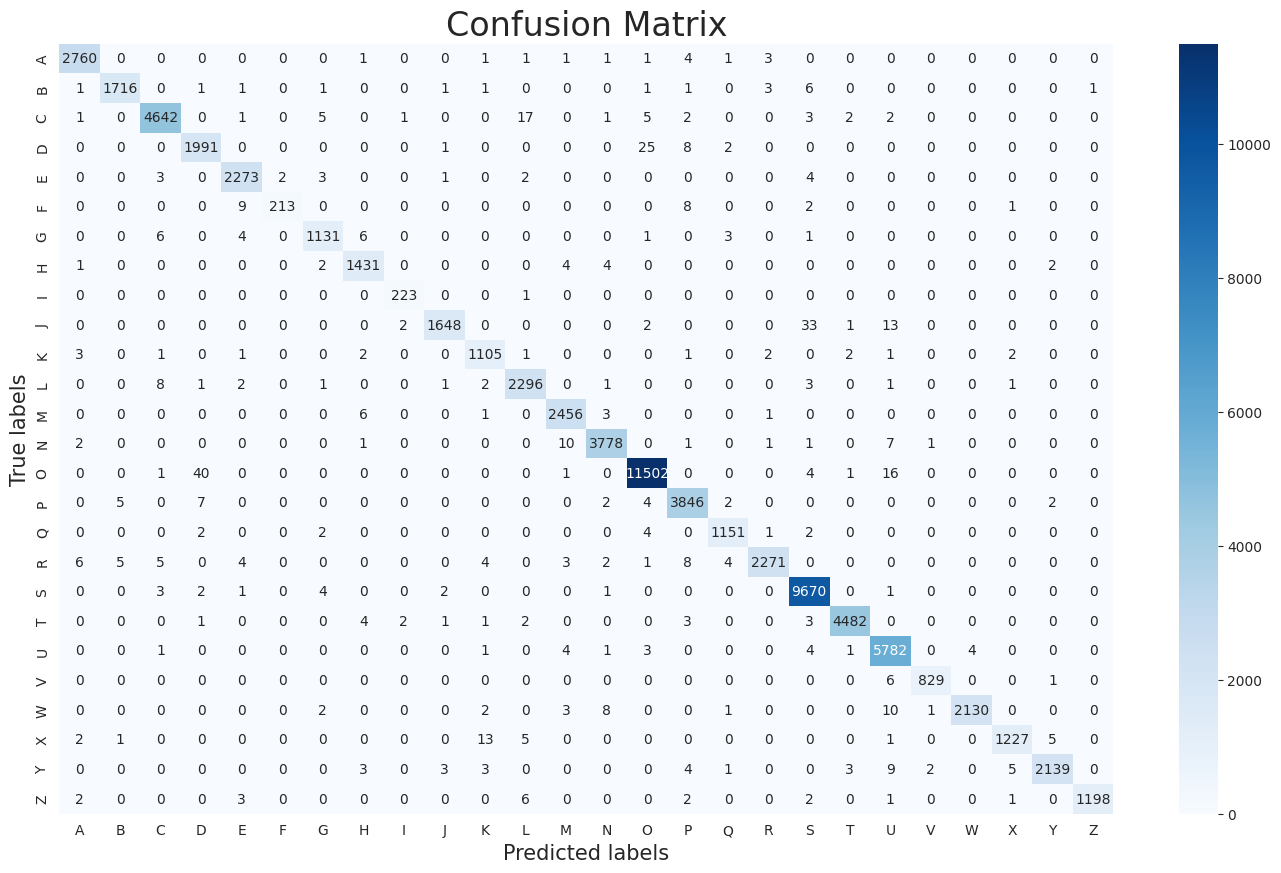

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_Test, [np.argmax(Preds[i]) for i in range(len(Preds))])

cm_with_letters = pd.DataFrame(cm, index=letters, columns=letters)

plt.figure(figsize=(17, 10))
sns.heatmap(cm_with_letters, annot=True, cmap='Blues', fmt='d')

plt.xlabel("Predicted labels", fontsize=15)
plt.ylabel("True labels", fontsize=15)
plt.title("Confusion Matrix", fontsize=24)
plt.show()

<h3>
<p>Accuracies for Each Letter</h3>
<p>

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer

PredictionsForLetters = [[] for _ in range(26)]
for i in range(len(Preds)):
    PredictionsForLetters[y_Test[i]].append(np.argmax(Preds[i])) 
#                     < Actual Value >        < Predicted Value >

AccuracyForLetters = []
for l in range(26):
    actual_values = [l]*len(PredictionsForLetters[l])
    AccuracyForLetters.append(accuracy_score(actual_values, PredictionsForLetters[l]))

AccuracyForLetters = dict(zip(letters, AccuracyForLetters))
print(AccuracyForLetters)

{'A': 0.9949531362653208, 'B': 0.9896193771626297, 'C': 0.9914566424604869, 'D': 0.9822397631968426, 'E': 0.9934440559440559, 'F': 0.9141630901287554, 'G': 0.9817708333333334, 'H': 0.9909972299168975, 'I': 0.9955357142857143, 'J': 0.9699823425544438, 'K': 0.9857270294380018, 'L': 0.9909365558912386, 'M': 0.9955411430887718, 'N': 0.9936875328774329, 'O': 0.9945525291828794, 'P': 0.9943123061013444, 'Q': 0.9905335628227194, 'R': 0.9818417639429312, 'S': 0.9985543163981826, 'T': 0.996221382529451, 'U': 0.9967247026374763, 'V': 0.9916267942583732, 'W': 0.9874826147426982, 'X': 0.9784688995215312, 'Y': 0.9848066298342542, 'Z': 0.9860082304526749}


<h3>
<p>Weighted Accuracy</h3>
<p>

Weighted accuracy is calculated by taking into account both the accuracy scores and the counts of each letter. Weighted Accuracy is nearly identical to the Accuracy obtained during the Evaluation phase.

In [0]:
LetterCountsForTestSet = dict(zip(letters, [0]*26))
for l in y_Test:
    LetterCountsForTestSet[letters[l]] += 1

Weighted_Accuracy = round(sum([AccuracyForLetters[l]*LetterCountsForTestSet[l] for l in letters])/len(y_Test), 3)
print(Weighted_Accuracy)

0.992


<h3>
<p>Comparison of Accuracies for Each Letter</h3>
<p>
The Accuracies for each letter, sorted in ascending order based on the weight of their corresponding characters in Test Set, are plotted in a Line Chart. Overall, it can be observed that having more images for a letter tends to result in more accurate predictions. Although the difference in accuracy is quite slight. 
Also, it is worth noting that there are some cases where this relationship is not consistent. However, it is interesting to observe that after the letter <b>'R'</b>, which has a count of 11566 in the entire dataset, every letter has an accuracy higher than 0.99.

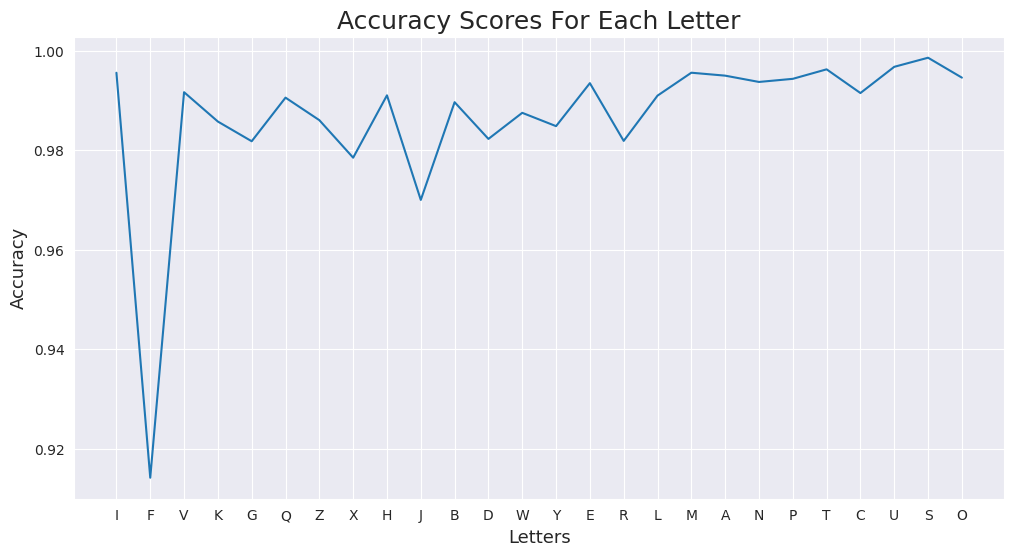

In [0]:
Accuracies_Sorted_Acc_To_Weight = sorted(AccuracyForLetters.items(), key=lambda x: LetterCountsForTestSet[x[0]])
LettersW, AccuraciesW = [i[0] for i in Accuracies_Sorted_Acc_To_Weight], [i[1] for i in Accuracies_Sorted_Acc_To_Weight]

fig = plt.figure(figsize=(12, 6))
sns.lineplot(x=LettersW, y=AccuraciesW)
plt.title('Accuracy Scores For Each Letter', fontsize=18)
plt.xlabel("Letters", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.show()

<h3>
<p>AUC Scores For Each Letter</h3>
<p>The CNN model achieved very high AUC scores for each letter, ranging from 0.99985 to 0.999999. They are excellent AUC scores, almost reaching 1.

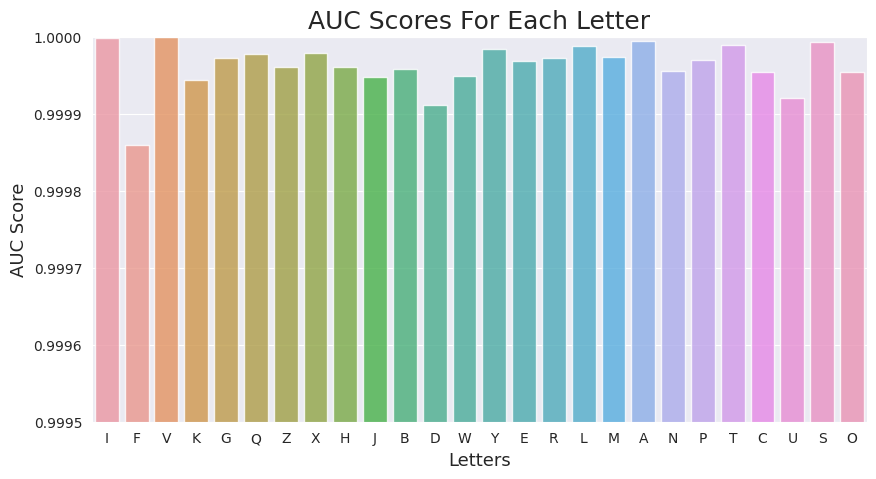

In [0]:
from sklearn.metrics import auc, roc_curve

AUC_Scores = {}
for i in range(26):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_Test, Preds[:,i], pos_label=i)
    AUC_Scores[i] = auc(false_positive_rate, true_positive_rate)

AUC_Scores_Sorted_Acc_To_Weight = dict(sorted(AUC_Scores.items(), key=lambda x: LetterCountsForTestSet[letters[x[0]]]))

fig = plt.figure(figsize=(10,5))
plt.ylim(0.9995, 1.0)

sns.barplot(x=[letters[i] for i in AUC_Scores_Sorted_Acc_To_Weight], y=list(AUC_Scores_Sorted_Acc_To_Weight.values()), alpha=.8)
plt.title('AUC Scores For Each Letter', fontsize=18)
plt.xlabel("Letters", fontsize=13)
plt.ylabel("AUC Score", fontsize=13)
plt.show()


<h3>
<p>ROC Curves For The Letters with The Lowest and The Highest AUC Scores</h3>
<p>In the figure below, the ROC Curves for the letter with minimum AUC score and the letter with maximum AUC score are drawn.

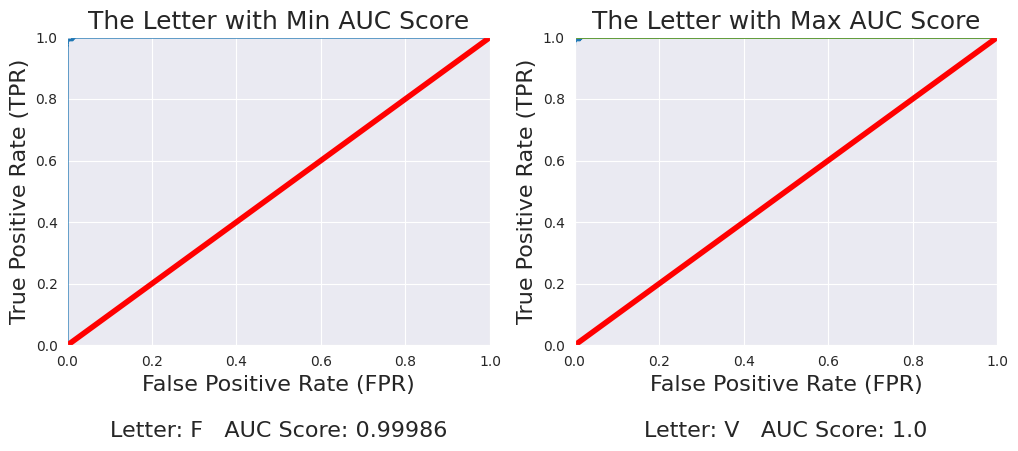

In [0]:
Letter_with_Max_AUC = [(i,AUC_Scores[i],"Max") for i in AUC_Scores if AUC_Scores[i] == max(AUC_Scores.values())][0]
Letter_with_Min_AUC = [(i,AUC_Scores[i],"Min") for i in AUC_Scores if AUC_Scores[i] == min(AUC_Scores.values())][0]

fig,axs=plt.subplots(1,2, figsize=(12, 4))

for index, la in enumerate([Letter_with_Min_AUC, Letter_with_Max_AUC]):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_Test, Preds[:,la[0]], pos_label=la[0])
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=la[0])

    axs[index].plot(false_positive_rate, true_positive_rate, linewidth=2, label='label')
    axs[index].plot([0, 1], [0, 1], 'r', linewidth=4)
    axs[index].axis([0, 1, 0, 1])
    axs[index].set_xlabel('False Positive Rate (FPR)\n\nLetter: '+str(letters[la[0]])+"   AUC Score: "+str(round(la[1],5)), fontsize=16)
    axs[index].set_ylabel('True Positive Rate (TPR)', fontsize=16)
    axs[index].set_title("The Letter with "+la[2]+" AUC Score", fontsize=18)

plt.show()

<h3>
<p>CONCLUSION</h3>
<p>
In summary, a Convolutional Neural Network (CNN) model was designed and successfully trained to identify handwritten letters, achieving an impressive accuracy score of 0.992. This high performance indicates its ability to correctly classify the letters. Furthermore, the model demonstrated its proficiency in minimizing errors during training with a low loss value of 0.035. Additionally, the near-perfect AUC scores for all letters further highlight the model's success in accurately identifying each letter.